In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sqrt import GainesSqrt
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rng = "Sobol"

unipolar
--- 0.5249996185302734 seconds ---
input error:  min: -0.00390625 , max: 0.0
output error: min: -0.07601457834243774 , max: 0.5
RMSE: 0.12683667931370612
MAE:  0.087165534
bias: 0.04993948


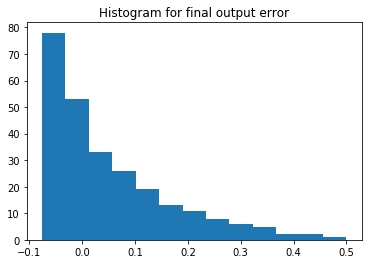

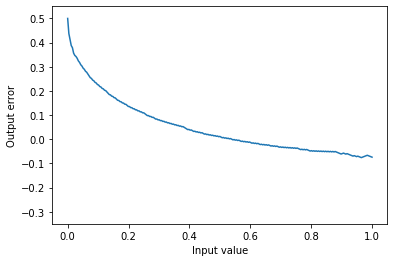

bipolar
--- 0.5229992866516113 seconds ---
input error:  min: 0.0 , max: 0.0
output error: min: -0.15545570850372314 , max: 0.4296875
RMSE: 0.1228121987064927
MAE:  0.10091136
bias: -0.018916937


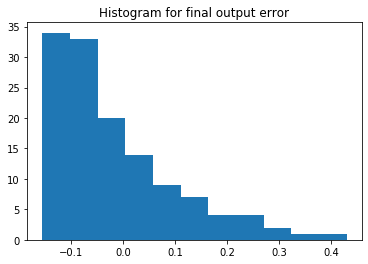

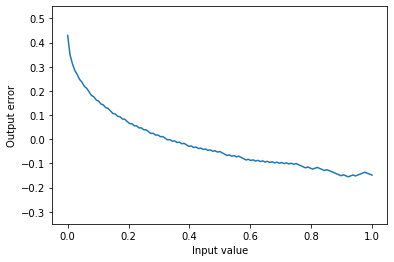

In [4]:
modes = ["unipolar", "bipolar"]
bitwidth = 8
depth=6
rng="Sobol"
rng_dim=2
stype = torch.float
rtype = torch.float

for mode in modes:
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)

    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)
    
    dut_sqrt = GainesSqrt(depth=depth, mode=mode, rng=rng, rng_dim=rng_dim, stype=stype).to(device)
    
    output = torch.sqrt(input).to(device)
    outputPE = ProgressiveError(output, mode=mode).to(device)
    
    inputPE  = ProgressiveError(input,  mode=mode).to(device)
    inputSRC = SourceGen(input, bitwidth, mode=mode, rtype=rtype)().to(device)
    inputRNG = RNG(bitwidth, 1, rng, rtype)().to(device)
    inputBS = BSGen(inputSRC, inputRNG, stype).to(device)

    with torch.no_grad():
        start_time = time.time()
        for i in range(2**bitwidth):
            input_bs = inputBS(torch.tensor([i]))
            inputPE.Monitor(input_bs)

            ouyput_bs = dut_sqrt(input_bs)   
            outputPE.Monitor(ouyput_bs)
        print("--- %s seconds ---" % (time.time() - start_time))
        print("input error: ", "min:", torch.min(inputPE()[1]).item(), ", max:", torch.max(inputPE()[1]).item())
        # set invalid output statistics to special values
        print("output error:", "min:", torch.min(outputPE()[1]).item(), ", max:", torch.max(outputPE()[1]).item())
        
        #######################################################################
        # check the error distribution using histogram
        #######################################################################
        result_pe = outputPE()[1].cpu().numpy()
        result_pe = result_pe.flatten()
        print("RMSE:", math.sqrt(np.mean(result_pe**2)))
        print("MAE: ", np.mean(np.abs(result_pe)))
        print("bias:", np.mean(result_pe))
        fig = plt.hist(result_pe, bins='auto', log=False)  # arguments are passed to np.histogram
        plt.title("Histogram for final output error")
        plt.show()
        
        #######################################################################
        # check the 3D plot contourf
        #######################################################################
        result_pe = outputPE()[1].cpu().numpy()
        fig = plt.figure()
        axis_len = outputPE()[1].size()[0]
        input_x_axis = []
        for axis_index in range(axis_len):
            input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
        cs = plt.plot(input_x_axis, result_pe)
        plt.xlabel('Input value')
        plt.ylabel('Output error')
        plt.ylim(-0.35, 0.55)
        plt.show()

In [5]:
def test(rng="Sobol", 
         mode="unipolar", 
         bitwidth=8, 
         total_cnt=100, 
         depth=5, 
         savepdf=False):
    stype = torch.float
    rtype = torch.float
    
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = 0
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)

    output = torch.sqrt(input).to(device)
    
    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        outputPE = ProgressiveError(output, mode=mode).to(device)

        inputPE  = ProgressiveError(input,  mode=mode).to(device)
        inputSRC = SourceGen(input, bitwidth, mode=mode, rtype=rtype)().to(device)
        
        dut_sqrt = GainesSqrt(depth=depth, mode=mode, rng=rng, rng_dim=4, stype=stype).to(device)
        
        inputRNG = RNG(bitwidth, rand_idx, rng, rtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                ouyput_bs = dut_sqrt(input_bs)
                outputPE.Monitor(ouyput_bs)
        
        # get the result for different rng
        result_pe = outputPE()[1].cpu().numpy()
        result_pe_total.append(result_pe)
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    
    #######################################################################
    # check the error of all simulation
    #######################################################################
    print("RMSE:{:1.4}".format(math.sqrt(np.mean(result_pe_total**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total))))
    print("bias:{:1.4}".format(np.mean(result_pe_total)))
    print("max: {:1.4}".format(np.max(result_pe_total)))
    print("min: {:1.4}".format(np.min(result_pe_total)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    max_total = np.max(result_pe_total, axis=0)
    min_total = np.min(result_pe_total, axis=0)
    avg_total = np.mean(result_pe_total, axis=0)
    
    axis_len = outputPE()[1].size()[0]
    input_x_axis = []
    for axis_index in range(axis_len):
        input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    fig, ax = plt.subplots()
    ax.fill_between(input_x_axis, max_total, avg_total, facecolor="red", alpha=0.75)
    ax.fill_between(input_x_axis, avg_total, min_total, facecolor="blue", alpha=0.75)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)

    plt.tight_layout()
    plt.xlabel('Input value')
    plt.ylabel('Output error')
    plt.xticks(np.arange(0, 1.1, step=0.5))
    # ax.xaxis.set_ticklabels([])
    plt.xlim(0, 1)
    plt.yticks(np.arange(-0.2, 0.4, step=0.2))
    # ax.yaxis.set_ticklabels([])
    plt.ylim(-0.3, 0.55)
    plt.grid(b=True, which="both", axis="y", linestyle="--", color="grey", linewidth=0.3)
    fig.set_size_inches(4, 4)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if savepdf is True:
        plt.savefig("sqrt-"+mode+"-bw"+str(bitwidth)+"-gaines-depth"+str(depth)+".pdf", 
                    dpi=300, 
                    bbox_inches='tight')
    plt.show()
    plt.close()

unipolar
RMSE:0.1074
MAE: 0.0725
bias:0.05237
max: 0.3945
min: -0.06638


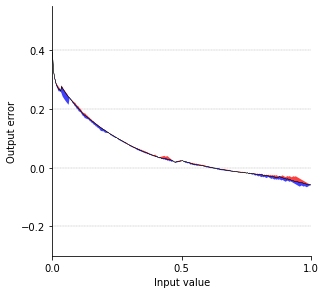

bipolar
RMSE:0.1172
MAE: 0.08843
bias:0.01492
max: 0.4062
min: -0.1405


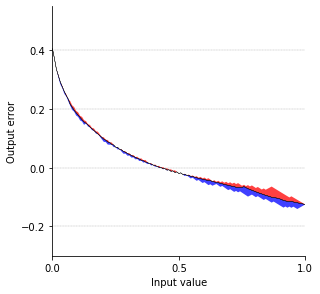

In [6]:
test(mode = "unipolar", bitwidth = 8, depth=5, savepdf=False)
test(mode = "bipolar", bitwidth = 8, depth=5, savepdf=False)